# New York City Crash Report 
## Group E (NYC Crashers)

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import requests
from sklearn.cluster import KMeans


# Reading and Assessment of Data 

In [80]:
df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', encoding='latin1')
df.info()

C:\Users\VANCE\AppData\Local\Temp\ipykernel_20664\3975778814.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', encoding='latin1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075653 entries, 0 to 2075652
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [81]:
df.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.842012e+06,1.842012e+06,2.075635e+06,2.075622e+06,2.075653e+06,2.075653e+06,2.075653e+06,2.075653e+06,2.075653e+06,2.075653e+06,2.075653e+06
mean,4.062750e+01,-7.375179e+01,3.098252e-01,1.494974e-03,5.655473e-02,7.414534e-04,2.679639e-02,1.151445e-04,2.228388e-01,6.152281e-04,3.159796e+06
std,1.982579e+00,3.726700e+00,6.999834e-01,4.077165e-02,2.440939e-01,2.769332e-02,1.634893e-01,1.077473e-02,6.611083e-01,2.713407e-02,1.505155e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066780e+01,-7.397484e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.155033e+06
50%,4.072083e+01,-7.392726e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.674067e+06
75%,4.076958e+01,-7.386673e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.193227e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.712514e+06


In [82]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
CRASH DATE,09/11/2021,03/26/2022,06/29/2022,09/11/2021,12/14/2021,04/14/2021,12/14/2021,12/14/2021,12/14/2021,12/14/2021
CRASH TIME,2:39,11:45,6:55,9:35,8:13,12:47,17:05,8:17,21:10,14:58
BOROUGH,NaN,NaN,NaN,BROOKLYN,BROOKLYN,NaN,NaN,BRONX,BROOKLYN,MANHATTAN
ZIP CODE,NaN,NaN,NaN,11208.0,11233.0,NaN,NaN,10475.0,11207.0,10017.0
LATITUDE,NaN,NaN,NaN,40.667202,40.683304,NaN,40.709183,40.86816,40.67172,40.75144
LONGITUDE,NaN,NaN,NaN,-73.8665,-73.917274,NaN,-73.956825,-73.83148,-73.8971,-73.97397
LOCATION,NaN,NaN,NaN,"(40.667202, -73.8665)","(40.683304, -73.917274)",NaN,"(40.709183, -73.956825)","(40.86816, -73.83148)","(40.67172, -73.8971)","(40.75144, -73.97397)"
ON STREET NAME,WHITESTONE EXPRESSWAY,QUEENSBORO BRIDGE UPPER,THROGS NECK BRIDGE,NaN,SARATOGA AVENUE,MAJOR DEEGAN EXPRESSWAY RAMP,BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,3 AVENUE
CROSS STREET NAME,20 AVENUE,NaN,NaN,NaN,DECATUR STREET,NaN,NaN,NaN,NaN,EAST 43 STREET
OFF STREET NAME,NaN,NaN,NaN,1211 LORING AVENUE,NaN,NaN,NaN,344 BAYCHESTER AVENUE,2047 PITKIN AVENUE,NaN


* Assessment of the data's top values

In [83]:
df["CONTRIBUTING FACTOR VEHICLE 1"].value_counts()

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                       706784
Driver Inattention/Distraction    415306
Failure to Yield Right-of-Way     123324
Following Too Closely             110939
Backing Unsafely                   76747
                                   ...  
Windshield Inadequate                 80
Cell Phone (hand-held)                79
Texting                               51
Listening/Using Headphones            24
1                                     10
Name: count, Length: 61, dtype: int64

In [84]:
for i in range(1,6):
    df_cfv = df["CONTRIBUTING FACTOR VEHICLE "+str(i)].value_counts()
    print(f"===================== Contributing factor {i} =============================")
    print(df_cfv)

===================== Contributing factor 1 =============================
CONTRIBUTING FACTOR VEHICLE 1
Unspecified                       706784
Driver Inattention/Distraction    415306
Failure to Yield Right-of-Way     123324
Following Too Closely             110939
Backing Unsafely                   76747
                                   ...  
Windshield Inadequate                 80
Cell Phone (hand-held)                79
Texting                               51
Listening/Using Headphones            24
1                                     10
Name: count, Length: 61, dtype: int64
===================== Contributing factor 2 =============================
CONTRIBUTING FACTOR VEHICLE 2
Unspecified                       1476611
Driver Inattention/Distraction      94262
Other Vehicular                     32068
Following Too Closely               19027
Failure to Yield Right-of-Way       17123
                                   ...   
Eating or Drinking                     11
Listening

In [85]:
df.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           645816
ZIP CODE                          646066
LATITUDE                          233641
LONGITUDE                         233641
LOCATION                          233641
ON STREET NAME                    440622
CROSS STREET NAME                 784541
OFF STREET NAME                  1727404
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6805
CONTRIBUTING FACTOR VEHICLE 2     321796
CONTRIBUTING FACTOR VEHICLE 3    1927369
CONTRIBUTING FACTOR VEHICLE 4    2042174
CONTRIBUTING FACTOR VEHICLE 5    2066582
COLLISION_ID                           0
VEHICLE TYPE COD

Seeeing as Columns CONTRIBUTING FACTOR VEHICLE 3-5 and VEHICLE TYPE CODE 3-5 are columns that are mostly empty we can drop these columns and focus on the main data in order to furhter our analysis.

In [86]:
df.drop(['CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5'],axis=1,inplace=True)
df.drop(['VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075653 entries, 0 to 2075652
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [87]:
v_type1 = df['VEHICLE TYPE CODE 1'].value_counts()

In [88]:
v_type2 = df['VEHICLE TYPE CODE 2'].value_counts()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sedan'),
  Text(1, 0, 'Station Wagon/Sport Utility Vehicle'),
  Text(2, 0, 'PASSENGER VEHICLE'),
  Text(3, 0, 'SPORT UTILITY / STATION WAGON'),
  Text(4, 0, 'Taxi'),
  Text(5, 0, '4 dr sedan'),
  Text(6, 0, 'Pick-up Truck'),
  Text(7, 0, 'TAXI'),
  Text(8, 0, 'VAN'),
  Text(9, 0, 'Box Truck')])

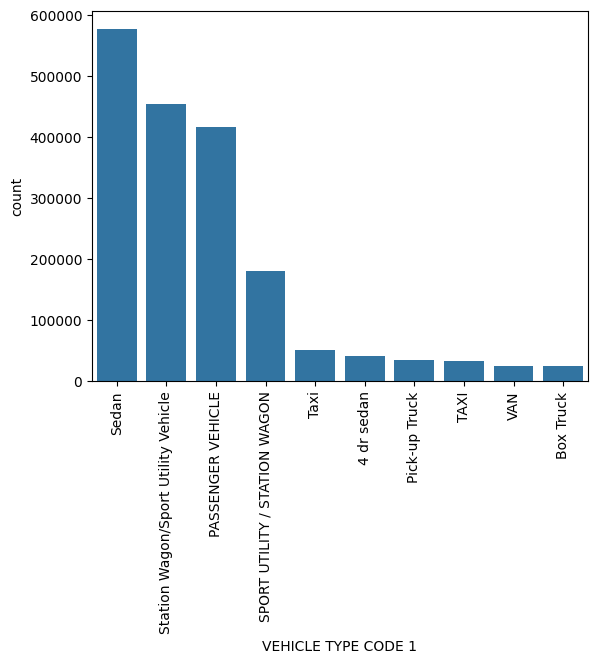

In [89]:
sns.barplot(v_type1[0:10])
plt.xticks(rotation=90)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sedan'),
  Text(1, 0, 'Station Wagon/Sport Utility Vehicle'),
  Text(2, 0, 'PASSENGER VEHICLE'),
  Text(3, 0, 'SPORT UTILITY / STATION WAGON'),
  Text(4, 0, 'UNKNOWN'),
  Text(5, 0, 'Taxi'),
  Text(6, 0, 'Bike'),
  Text(7, 0, 'Pick-up Truck'),
  Text(8, 0, '4 dr sedan'),
  Text(9, 0, 'Box Truck')])

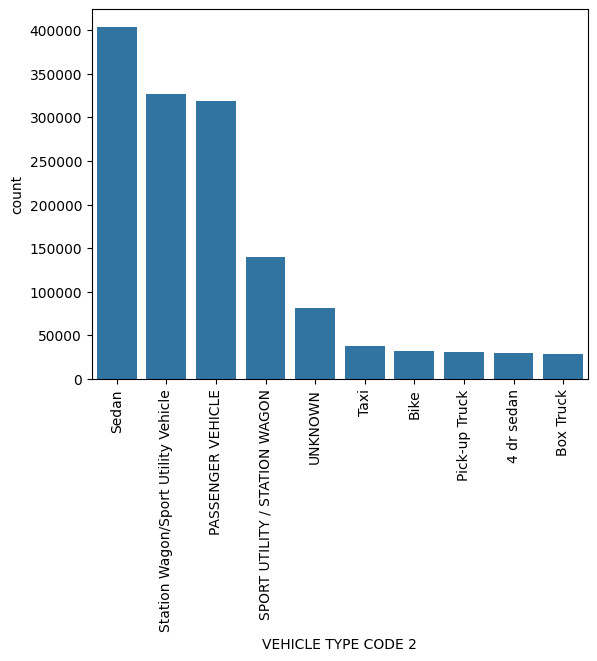

In [90]:
sns.barplot(v_type2[0:10])
plt.xticks(rotation=90)

The API application that is proposed will most likely be built using a K-Means clustering algorithm so in this case the best feature to use would be the longitude and latitude features. However some coordinates are missing so if the street names are provided for those missing rows, the values can be obtained using the OpenStreetMap Nominatim  API.

In [91]:
df_no_locs = df[df['LOCATION'].isna()]
df_street_names = df_no_locs[df_no_locs['ON STREET NAME'].notna()].shape

From the column above there are 177173 columns where the street name is known but not the location so we can input this data into the OpenStreetMap Nominatim API and get the approximate coordinates of the accidents. Since the dataset is soo large the other rows where the data is not known can simply be dropped as it may not have a ssignificant effect on the outcome of the analysis.

In [92]:
df= df.dropna(subset=['LATITUDE', 'LONGITUDE', 'LOCATION'])

In [98]:
def replace_with_cluster_center(row):
    cluster_center = cluster_centers[row['Cluster']]
    row['Avg_LATITUDE'] = cluster_center[0]
    row['Avg_LONGITUDE'] = cluster_center[1]
    return row


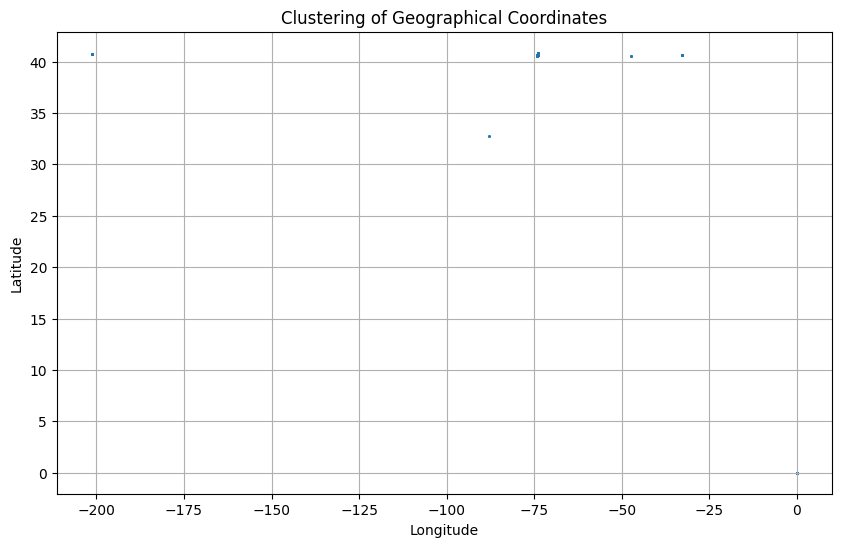

In [99]:
X = df[['LATITUDE', 'LONGITUDE']]

n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_

labels = kmeans.labels_

df['Cluster'] = labels


df_with_avg_coords = df.apply(replace_with_cluster_center, axis=1)


plt.figure(figsize=(10, 6))
plt.scatter(df_with_avg_coords['Avg_LONGITUDE'], df_with_avg_coords['Avg_LATITUDE'], s=1) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Geographical Coordinates')
plt.grid(True)
plt.show()

In [97]:
df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,Cluster
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,0,0,0,0,Unspecified,NaN,4456314,Sedan,NaN,6
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,0,0,0,0,NaN,NaN,4486609,NaN,NaN,6
6,12/14/2021,17:05,NaN,NaN,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,0,0,0,0,Passing Too Closely,Unspecified,4486555,Sedan,Tractor Truck Diesel,13
7,12/14/2021,8:17,BRONX,10475.0,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,0,0,2,0,Unspecified,Unspecified,4486660,Sedan,Sedan,7
8,12/14/2021,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,0,0,0,0,Driver Inexperience,Unspecified,4487074,Sedan,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075648,03/23/2024,17:45,QUEENS,11106.0,40.760048,-73.928060,"(40.760048, -73.92806)",30 STREET,34 AVENUE,NaN,...,0,0,1,0,Failure to Yield Right-of-Way,Unspecified,4712188,Station Wagon/Sport Utility Vehicle,Sedan,19
2075649,03/23/2024,5:33,BROOKLYN,11208.0,40.685696,-73.871610,"(40.685696, -73.87161)",RIDGEWOOD AVENUE,HEMLOCK STREET,NaN,...,0,0,1,0,Unsafe Speed,Unspecified,4712016,Sedan,NaN,6
2075650,03/22/2024,4:00,BRONX,10452.0,40.835445,-73.923386,"(40.835445, -73.923386)",SHAKESPEARE AVENUE,JEROME AVENUE,NaN,...,0,0,0,0,Backing Unsafely,Unspecified,4712480,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,14
2075651,03/23/2024,6:43,BRONX,10451.0,40.816532,-73.928220,"(40.816532, -73.92822)",GRAND CONCOURSE,EAST 144 STREET,NaN,...,0,0,1,0,Fell Asleep,NaN,4712505,Station Wagon/Sport Utility Vehicle,NaN,14
